In [16]:
import matplotlib
matplotlib.use('TkAgg')

import requests
import urllib.request
import keras
import sklearn
import sklearn.cross_validation

import pandas as pd
import seaborn as sns
import numpy as np

from pathlib import Path

%matplotlib inline

/Users/peekabuy/projects/detect_clothes/env/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
# import data
r = requests.get('https://test.flaunt.peekabuy.com/api/board/get_jc_product_images_batch/?page=3')

In [7]:
image_urls = r.json()['images']

In [15]:
data_dir = Path('../data/raw')

for url in image_urls:
    splits = url.split('/')
    filename = splits[-1]
    filepath = data_dir / filename
    urllib.request.urlretrieve(url, str(filepath))
    

../data/4fbedb7bf74ebea3381a5f94ef413eac.jpg
../data/661f7f5b758dad38ac6fdf3922c648e4.jpg
../data/97db99ef15d57e2779b6798462023659.jpg
../data/186d262630df3cbd68012ab89ba71e35.jpg
../data/92c8032a9a040ad2c68dff2918f458e6.jpg
../data/a0699e1cac5faf222ce1e8009ffae59a.jpg
../data/5e52345a3a1fe6709eb5de229b13479c.jpg
../data/a0e0ee65222834586338f17ce10e87eb.jpg
../data/a6d379e60044ee743d47e6eabe35386d.jpg
../data/80e77b7aab508f91862a11d0edd89bbc.jpg
../data/748c6281ba693ed4f3ecc486d017dd50.jpg
../data/93ba72bc36d1c2e0efd15fd21e910d32.jpg
../data/530bcb6c7858f32df07301728ae49da1.jpg
../data/f3ffb4577141d62aeb3709e6e6424c45.jpg
../data/3d7276af693af671a3d5a2f3cc06bc0e.jpg
../data/6165f54a8c68de1dad78db2a79e96c63.jpg
../data/0c6fe551acc18ac002b3e8084048743c.jpg
../data/7c2e0159e68207a35a8ff69238cf63ae.jpg
../data/5664037d3669fbcb93aee4d03942e3dd.jpg
../data/39bf523d1eb84d6ece22e481cc32edc3.jpg
../data/f121e9ac236e0e12b515b8e0d4b3de62.jpg
../data/5b6191cd14ac7a09f5b924a72958d91c.jpg
../data/a5

- Do dresses with shirts count as one thing or two things
    - try treating as one piece
- Should clothes with people in them be rejected
    - 
- Should clothes with weird backgrounds (i.e. white on white) be rejected also
    - classify them out
    
    
Do fine-grained annotation but try bucketing / not bucketing the labels

There's a list of labels that should be fed through the existing cropping pipeline and a list that need to be further examined

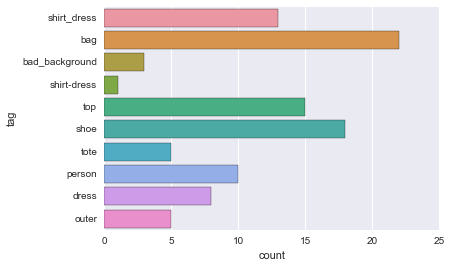

In [25]:
gt_labels = pd.read_csv('../data/raw.csv', header=None, names=['image_name', 'tag'])

sns.countplot(data=gt_labels, y='tag')

In [18]:
# fine-grained first pass

# create directory of symlinks
train_finegrain_dir = Path('../data/train_finegrain')
if not train_finegrain_dir.exists():
    train_finegrain_dir.mkdir()

# generate stratified split
X = gt_labels.image_name
y = gt_labels.tag
print(y)

X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(X, y, test_size=0.1, stratify=y)

0        shirt_dress
1                bag
2     bad_background
3                bag
4        shirt-dress
5                top
6               shoe
7                bag
8               tote
9                top
10               bag
11               top
12               bag
13       shirt_dress
14              shoe
15            person
16              shoe
17            person
18       shirt_dress
19    bad_background
20              shoe
21               bag
22               bag
23               top
24             dress
25               bag
26               bag
27               top
28       shirt_dress
29       shirt_dress
           ...      
70             dress
71       shirt_dress
72       shirt_dress
73             dress
74             outer
75              shoe
76              shoe
77       shirt_dress
78              shoe
79       shirt_dress
80    bad_background
81              shoe
82              shoe
83              tote
84              shoe
85             dress
86           

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of labels for any class cannot be less than 2.